Loading training dataset...
Loading images from folder: /content/drive/MyDrive/archive/data/train/fractured
Loaded 4480 images from /content/drive/MyDrive/archive/data/train/fractured
Loading images from folder: /content/drive/MyDrive/archive/data/train/not fractured
Loaded 4383 images from /content/drive/MyDrive/archive/data/train/not fractured
Combining training datasets...
Loading validation dataset...
Loading images from folder: /content/drive/MyDrive/archive/data/val/fractured
Loaded 360 images from /content/drive/MyDrive/archive/data/val/fractured
Loading images from folder: /content/drive/MyDrive/archive/data/val/not fractured
Loaded 240 images from /content/drive/MyDrive/archive/data/val/not fractured
Combining validation datasets...
Training the Naive Bayes model...
Naive Bayes model training completed.
Training the MLP model...
Iteration 1, loss = 5.99307737
Iteration 2, loss = 0.69379226
Iteration 3, loss = 0.69372733
Iteration 4, loss = 0.69366246
Iteration 5, loss = 0.6935

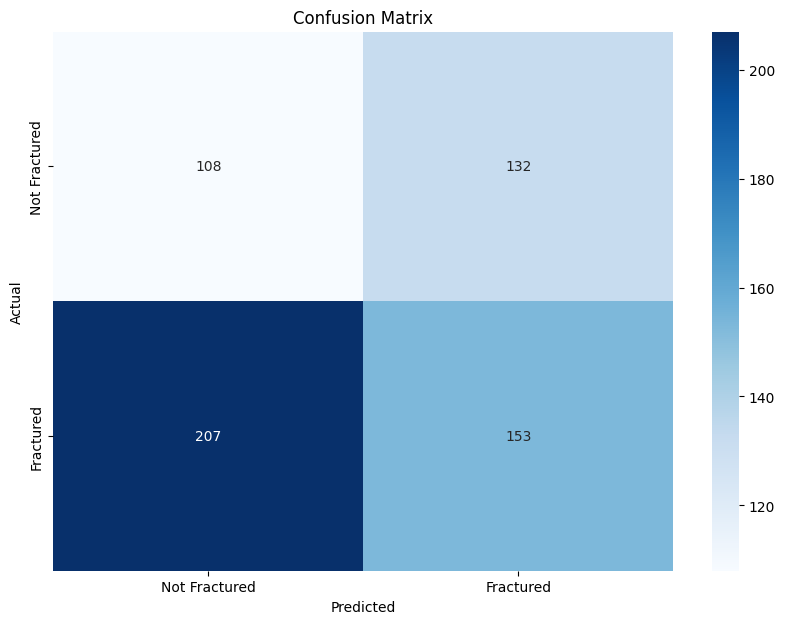

Saving the ensemble model to a file...
Ensemble model saved successfully.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Function to load images and labels from a specified folder
def load_images_from_folder(folder, label):
    images = []
    labels = []
    print(f"Loading images from folder: {folder}")
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize images to a fixed size
            images.append(img.flatten())  # Flatten the image
            labels.append(label)
    print(f"Loaded {len(images)} images from {folder}")
    return images, labels

# Load training dataset
print("Loading training dataset...")
train_fractured_images, train_fractured_labels = load_images_from_folder('/content/drive/MyDrive/archive/data/train/fractured', 1)
train_not_fractured_images, train_not_fractured_labels = load_images_from_folder('/content/drive/MyDrive/archive/data/train/not fractured', 0)

# Combine the training datasets
print("Combining training datasets...")
train_images = np.array(train_fractured_images + train_not_fractured_images)
train_labels = np.array(train_fractured_labels + train_not_fractured_labels)

# Load validation dataset
print("Loading validation dataset...")
val_fractured_images, val_fractured_labels = load_images_from_folder('/content/drive/MyDrive/archive/data/val/fractured', 1)
val_not_fractured_images, val_not_fractured_labels = load_images_from_folder('/content/drive/MyDrive/archive/data/val/not fractured', 0)

# Combine the validation datasets
print("Combining validation datasets...")
val_images = np.array(val_fractured_images + val_not_fractured_images)
val_labels = np.array(val_fractured_labels + val_not_fractured_labels)

# Train a Naive Bayes model
print("Training the Naive Bayes model...")
naive_bayes = MultinomialNB()
naive_bayes.fit(train_images, train_labels)
print("Naive Bayes model training completed.")

# Train an MLP model
print("Training the MLP model...")
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, verbose=True, tol=1e-4, n_iter_no_change=50)
mlp_classifier.fit(train_images, train_labels)
print("MLP model training completed.")

# Create a voting ensemble
print("Creating the voting ensemble...")
ensemble = VotingClassifier(estimators=[
    ('naive_bayes', naive_bayes),
    ('mlp_classifier', mlp_classifier)
], voting='soft')  # Use 'hard' for majority voting, 'soft' for weighted probabilities

# Train the ensemble model
print("Training the ensemble model...")
ensemble.fit(train_images, train_labels)

# Make predictions with the ensemble model
print("Making predictions with the ensemble model...")
val_pred_ensemble = ensemble.predict(val_images)

# Evaluate the ensemble model
print("Evaluating the ensemble model...")
accuracy = accuracy_score(val_labels, val_pred_ensemble)
precision = precision_score(val_labels, val_pred_ensemble)
recall = recall_score(val_labels, val_pred_ensemble)
f1 = f1_score(val_labels, val_pred_ensemble)
conf_matrix = confusion_matrix(val_labels, val_pred_ensemble)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Plot confusion matrix
print("Plotting confusion matrix...")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fractured', 'Fractured'], yticklabels=['Not Fractured', 'Fractured'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the ensemble model to a file
print("Saving the ensemble model to a file...")
with open('ensemble_xray_model.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

print("Ensemble model saved successfully.")
